# Visualization of the output of a Convolutional Layer

In this notebook I will show you how to visualize the output of two Convolutional Neural Network (CNN) layers using tensorflow. In addition, you will see some of the filters.  
First we import tensorflow, numpy for matrix shape manipulation and pyplot for the visualization.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


Then we will import the MNIST dataset. Don't worry we will manipulate the data so you could be able to repeat this process with your own data.

In [3]:
#https://www.tensorflow.org/get_started/mnist/beginners

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The previous cell downloads the training, validation and test sets of images into the variable **mnist**. We can see this by calling help, within the **"Data descriptors zone"**.

In [6]:
print(help(mnist))

Help on Datasets in module tensorflow.contrib.learn.python.learn.datasets.base object:

class Datasets(builtins.tuple)
 |  Datasets(train, validation, test)
 |  
 |  Method resolution order:
 |      Datasets
 |      builtins.tuple
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getnewargs__(self)
 |      Return self as a plain tuple.  Used by copy and pickle.
 |  
 |  __repr__(self)
 |      Return a nicely formatted representation string
 |  
 |  _asdict(self)
 |      Return a new OrderedDict which maps field names to their values.
 |  
 |  _replace(_self, **kwds)
 |      Return a new Datasets object replacing specified fields with new values
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined here:
 |  
 |  _make(iterable, new=<built-in method __new__ of type object at 0x7fe83619aae0>, len=<built-in function len>) from builtins.type
 |      Make a new Datasets object from a sequence or iterable
 |  
 |  ----------

To see how to work with these data we call help again and see that the training set has **images** and **labels**, what we need for now.

In [7]:
print(help(mnist.train))

Help on DataSet in module tensorflow.contrib.learn.python.learn.datasets.mnist object:

class DataSet(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, images, labels, fake_data=False, one_hot=False, dtype=tf.float32, reshape=True, seed=None)
 |      Construct a DataSet.
 |      one_hot arg is used only if fake_data is true.  `dtype` can be either
 |      `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
 |      `[0, 1]`.  Seed arg provides for convenient deterministic testing.
 |  
 |  next_batch(self, batch_size, fake_data=False, shuffle=True)
 |      Return the next `batch_size` examples from this data set.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  epochs_completed
 |  
 |  images
 |  
 |  labels
 |  
 |  num_examp

Then we see how many data we have here.

In [11]:
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

(55000, 784)
(55000, 10)


# The hardest part, definition of layers

Here are three main functions. If more information is required please send me an email or comment if you need further explanation.  
In summary, **get_previous_features** will get all the dimensions of a matrix and compute how many they are. For example if there is [10,256,256,3] matrix, this function will return 256\*256\*3 , we skip the the first dimension **10** because it is for the batch.  
**conv** will create a convolutional layer wi a **relu** activation by default. Some key terms here, **name_scope** and **name**. This two parameters will help us call the declared operations by name. For example, the **tf.nn.conv2d** with name **conv** for a name_scope=**CL1** could be called **CL1/conv**, technically **CL1/conv:0**. In addition, to get the trained weights, **CL1/W**/**CL1/W:0**.   
**fc** will return a fully connected layer, if the name scope is declared as **FCL** it corresponds to the output layer.  
**is_training**: This variable will tell to normalize the layers with its corresponding meand and variance and store them Exponential Moving Average (EMA) the values for normalization or load this EMA to normalize prediciton or testing inputs.

In [35]:

def get_previous_features(i_layer):
    convx_dims = i_layer.get_shape().as_list()
    output_features = 1
    for dim in range(1,len(convx_dims)):
        output_features=output_features*convx_dims[dim]
    return output_features



def conv(input_matrix,filter_size=3,layer_depth=8,
              strides=[1,1,1,1],padding='SAME',
              is_training=True,name_scope="lx",
              stddev_n = 0.05,
             max_bool=False,max_kernel=[1,2,2,1],max_strides=[1,1,1,1], max_padding='SAME',
             drop_out_bool=False,drop_out_ph=None,drop_out_v=None,decay=0.5
             ):
    with tf.name_scope(name_scope):
        ims = input_matrix.get_shape().as_list()
        input_depth=ims[len(ims)-1]
        W = tf.Variable(tf.truncated_normal([filter_size,filter_size,input_depth,layer_depth], stddev=stddev_n),name='W')
        b = tf.Variable(tf.constant(stddev_n, shape=[layer_depth]),name='b')
        c = tf.add(tf.nn.conv2d(input_matrix, W, strides=strides, padding=padding),b,name='conv')
        n = tf.contrib.layers.batch_norm(c, center=True, scale=True, is_training=is_training,decay=decay)
        a = tf.nn.relu(n,name="activation")
        if max_bool==True:
            out = tf.nn.max_pool(a, ksize=max_kernel,strides=max_strides, padding=max_padding,name='max')
        else:
            out = a
        if drop_out_bool==True:
            out_  = tf.nn.dropout(out, drop_out_ph)
        else:
            out_ = out
        return out_


def fc(input_matrix,n=22,norm=False,prev_conv=False,
       stddev_n = 0.05,is_training=True,
       name_scope='FC',drop_out_bool=False,drop_out_ph=None,drop_out_v=None,decay=0.5):
    with tf.name_scope(name_scope):
        cvpfx = get_previous_features(input_matrix)
        if prev_conv==True:
            im = tf.reshape(input_matrix, [-1, cvpfx])
        else:
            im = input_matrix
        W = tf.Variable(tf.truncated_normal([cvpfx, n], stddev=stddev_n),name='W')
        b = tf.Variable(tf.constant(stddev_n, shape=[n]),name='b') 
        fc = tf.add(tf.matmul(im, W),b,name="FC")
        if name_scope=="FCL":
            out_ = fc
        else:
            if norm==True:
                n = tf.contrib.layers.batch_norm(fc, center=True, scale=True, is_training=is_training,decay=decay)
                out = tf.nn.relu(n,name="activation")
            else:
                out = tf.nn.relu(fc,name="activation")
            if drop_out_bool==True:
                out_  = tf.nn.dropout(out, drop_out_ph)
            else:
                out_ = out
        return out_


Here we define our model and the way to train it. We have some basic blocks, the placeholders that will be set by an outside call. The shapes of the place holders will be modified by what you feed into it.  
We define if we want to save the model and if we want to restore the model for training. Please notice that we set the name_scope **CL1** and **CL2**.

In [63]:
def train(ix,iy,iters=10,lr=0.001,save_model=True,save_name=None,restore_model=False,restore_name=None,v=False):
    "v: for verbosity"
    tf.reset_default_graph()
    class_output = iy.shape[1]
    d0 = ix.shape[0]
    x_shape=[None]
    for _ in range(1,len(ix.shape)):
        x_shape.append(ix.shape[_])
    xi = tf.placeholder(tf.float32, shape=x_shape,name='x')
    y_ = tf.placeholder(tf.float32, shape=[None,class_output],name='y')
    train_bool=tf.placeholder(bool,name='train_test')
    learning_rate = tf.placeholder(tf.float32)
    
    #Define the model here--DOWN
    CV1 = conv(xi,filter_size=3,layer_depth=2,name_scope="CL1",is_training=train_bool)
    CV2 = conv(CV1,filter_size=3,layer_depth=2,name_scope="CL2",is_training=train_bool)
    prediction = fc(CV2,n=10,name_scope="FCL",prev_conv=True)
    #Define the model here--UP
    
    y_CNN = tf.nn.softmax(prediction,name='Softmax')
    class_pred = tf.argmax(y_CNN,1,name='ClassPred')
    loss = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_CNN), reduction_indices=[1]),name="loss")
    
    #The following three lines are required to make "is_training" work for normalization
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    init_op = tf.global_variables_initializer()
    
    saver = tf.train.Saver()
    with tf.Session() as s:
        if restore_model==True:
            if restore_name==None:
                print("No model file specified")
                return
            else:
                saver.restore(s,restore_dir)
        else:
            s.run(init_op)
        fd={xi:ix,y_:iy,learning_rate:lr,train_bool:True}
        for _ in range(0,iters):
            _t,l = s.run([train_step,loss],feed_dict=fd)
            if v==True:
                print("Iter:",_,"Loss:",l)
            
        if save_model==True:
            if save_name==None:
                print("No model specified, model not being saved")
                return
            else:
                save_path = saver.save(s, save_name)
                print("Model saved in file: %s" % save_name)


Here we modify the mnist data to have a shape of [batch_size,image_with,image_height,channels] where channels is 1, because it is in grayscale.  
We define the model where to save as **base_model**

In [64]:
base_model = 'MNIST/mnist_01_.ckpt'

mtx = mnist.train.images
mtx_s = mtx.shape
x_train = np.reshape(mtx,[mtx_s[0],int(mtx_s[1]**0.5),int(mtx_s[1]**0.5),1])
print("Train shape",mtx_s)
print(x_train.shape)

limit = 16
shift = 0
y_train = mnist.train.labels

xt = x_train[shift:shift+limit,:]
yt = y_train[shift:shift+limit,:]

train(ix=xt,iy=yt,iters=10,lr=0.001,save_model=True,save_name=base_model,restore_model=False,restore_name=None)

Train shape (55000, 784)
(55000, 28, 28, 1)
Model saved in file: MNIST/mnist_01_.ckpt


In the previous cell we trained only for 10 iterations on purpose to see the base state of the results of these layers and the weights.  
The next cell is the function that will allow us to call the output whether it is the convolution operation or the weights. The **var_name** is for this purpose.


In [32]:
def restore_see_layer(ix,model_name=None,var_name=None):
    with tf.Session('', tf.Graph()) as s:
        with s.graph.as_default():
            if (model_name!=None) and var_name!=None:
                saver = tf.train.import_meta_graph(model_name+".meta")
                saver.restore(s,model_name)
                fd={'x:0':ix,'train_test:0':False}
                var_name=var_name+":0"
                result = s.run(var_name,feed_dict=fd)
    return result

Here we call out function and see the shape of the output.  
the **test_img** will hold our test image from the mnist dataset. Instead of doing xt[0,:], we do xt[0:1,:] to keep the shape [1,28,28,1], otherwise we will get a [28,28] matrix.  
As we can see as we declared in our model, we got **2** depth channels for the CL1 and CL2 convs.  


In [67]:
test_img = xt[0:1,:]

output_cl1 = restore_see_layer(ix=test_img,model_name=base_model,var_name='CL1/conv')
print(output_cl1.shape)

output_cl2 = restore_see_layer(ix=test_img,model_name=base_model,var_name='CL2/conv')
print(output_cl2.shape)


INFO:tensorflow:Restoring parameters from MNIST/mnist_01_.ckpt
(1, 28, 28, 2)
INFO:tensorflow:Restoring parameters from MNIST/mnist_01_.ckpt
(1, 28, 28, 2)


# Let's visualize them!

Now we define a function to ease the visualization for the output. The **depth_filter_to_see** will select with channel of the depth of the output we want to see. Each one will provide a different result.  

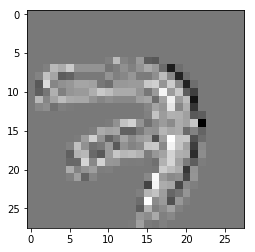

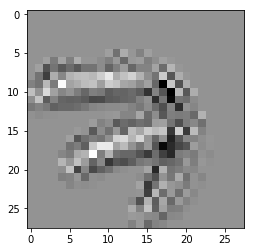

In [68]:
def see_output(iNp,depth_filter_to_see=0,cmap="gray",figsize=(4,4)):
    img_x = iNp[0,:,:,depth_filter_to_see]
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_x,cmap=cmap)
    plt.show()

see_output(output_cl1,1)
see_output(output_cl2,1)


As we saw, the outputs are different.  
Now, what happens after 1000 iterations?  

In [69]:
train(ix=xt,iy=yt,iters=1000,lr=0.001,save_model=True,save_name=base_model,restore_model=False,restore_name=None,v=True)

Iter: 0 Loss: 2.79147
Iter: 1 Loss: 2.32892
Iter: 2 Loss: 1.93102
Iter: 3 Loss: 1.59006
Iter: 4 Loss: 1.29672
Iter: 5 Loss: 1.0444
Iter: 6 Loss: 0.827575
Iter: 7 Loss: 0.644254
Iter: 8 Loss: 0.491302
Iter: 9 Loss: 0.367425
Iter: 10 Loss: 0.270061
Iter: 11 Loss: 0.196526
Iter: 12 Loss: 0.142641
Iter: 13 Loss: 0.103913
Iter: 14 Loss: 0.0763166
Iter: 15 Loss: 0.0567833
Iter: 16 Loss: 0.0429254
Iter: 17 Loss: 0.0330122
Iter: 18 Loss: 0.0258093
Iter: 19 Loss: 0.0205094
Iter: 20 Loss: 0.0165604
Iter: 21 Loss: 0.0136019
Iter: 22 Loss: 0.0113298
Iter: 23 Loss: 0.00956494
Iter: 24 Loss: 0.00818789
Iter: 25 Loss: 0.00709464
Iter: 26 Loss: 0.00621003
Iter: 27 Loss: 0.00549146
Iter: 28 Loss: 0.00490289
Iter: 29 Loss: 0.00441662
Iter: 30 Loss: 0.00401183
Iter: 31 Loss: 0.00367067
Iter: 32 Loss: 0.0033806
Iter: 33 Loss: 0.00313209
Iter: 34 Loss: 0.00291907
Iter: 35 Loss: 0.00273428
Iter: 36 Loss: 0.00257343
Iter: 37 Loss: 0.00243271
Iter: 38 Loss: 0.00230909
Iter: 39 Loss: 0.00219957
Iter: 40 Loss: 

We repeat the visulization steps and see that indeed the output is different

INFO:tensorflow:Restoring parameters from MNIST/mnist_01_.ckpt
(1, 28, 28, 2)
INFO:tensorflow:Restoring parameters from MNIST/mnist_01_.ckpt
(1, 28, 28, 2)


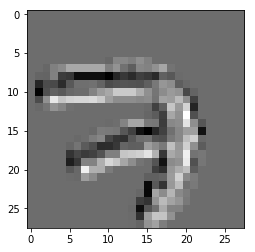

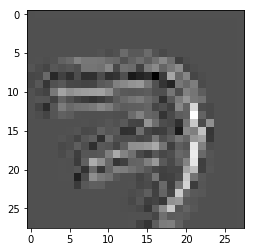

In [70]:
output_cl1 = restore_see_layer(ix=test_img,model_name=base_model,var_name='CL1/conv')
print(output_cl1.shape)

output_cl2 = restore_see_layer(ix=test_img,model_name=base_model,var_name='CL2/conv')
print(output_cl2.shape)

see_output(output_cl1,1)
see_output(output_cl2,1)


## What about the filters (trained weights)?

Now, the output of the weights have a different shape, [fs,fs,input_depth,output_depth], where **fs** is the filter size. For our model we set the default value as 3. Therefore, our first weight has the shape [3,3,1,2], 1 is the input channel of grayscale of the image and 2 the depth we set. In addition, out second weight has the shape [3,3,2,2], the third parameter is 2, because the channels from the previous layer are 2.  
For this example we are setting this second parameter as 0.  

INFO:tensorflow:Restoring parameters from MNIST/mnist_01_.ckpt
(3, 3, 1, 2)
INFO:tensorflow:Restoring parameters from MNIST/mnist_01_.ckpt
(3, 3, 2, 2)


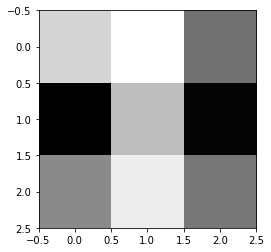

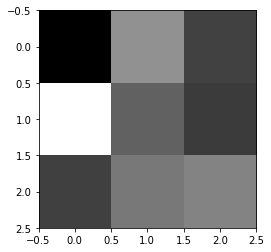

In [71]:
def see_filter(iNp,depth_filter_to_see=0,input_depth_filter_to_see=0,cmap="gray",figsize=(4,4)):
    img_x = iNp[:,:,input_depth_filter_to_see,depth_filter_to_see]
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_x,cmap=cmap)
    plt.show()


output_cl1_filter = restore_see_layer(ix=test_img,model_name=base_model,var_name='CL1/W')
print(output_cl1_filter.shape)

output_cl2_filter = restore_see_layer(ix=test_img,model_name=base_model,var_name='CL2/W')
print(output_cl2_filter.shape)

see_filter(output_cl1_filter,1)
see_filter(output_cl2_filter,1)

## Do you want to see max pooling ?

Now we define another function **train_max** with the purpose to have a model with max_pool. to enable this with out **conv** function we set **max_bool=True**.  

In [72]:
def train_max(ix,iy,iters=10,lr=0.001,save_model=True,save_name=None,restore_model=False,restore_name=None,v=False):
    "v: for verbosity"
    tf.reset_default_graph()
    class_output = iy.shape[1]
    d0 = ix.shape[0]
    x_shape=[None]
    for _ in range(1,len(ix.shape)):
        x_shape.append(ix.shape[_])
    xi = tf.placeholder(tf.float32, shape=x_shape,name='x')
    y_ = tf.placeholder(tf.float32, shape=[None,class_output],name='y')
    train_bool=tf.placeholder(bool,name='train_test')
    learning_rate = tf.placeholder(tf.float32)
    
    CV1 = conv(xi,filter_size=3,layer_depth=2,name_scope="CL1",is_training=train_bool,max_bool=True)
    CV2 = conv(CV1,filter_size=3,layer_depth=2,name_scope="CL2",is_training=train_bool,max_bool=True)
    prediction = fc(CV2,n=10,name_scope="FCL",prev_conv=True)
    
    y_CNN = tf.nn.softmax(prediction,name='Softmax')
    class_pred = tf.argmax(y_CNN,1,name='ClassPred')
    loss = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_CNN), reduction_indices=[1]),name="loss")
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    init_op = tf.global_variables_initializer()
    
    saver = tf.train.Saver()
    with tf.Session() as s:
        if restore_model==True:
            if restore_name==None:
                print("No model file specified")
                return
            else:
                saver.restore(s,restore_dir)
        else:
            s.run(init_op)
        fd={xi:ix,y_:iy,learning_rate:lr,train_bool:True}
        for _ in range(0,iters):
            _t,l = s.run([train_step,loss],feed_dict=fd)
            if v==True:
                print("Iter:",_,"Loss:",l)
            
        if save_model==True:
            if save_name==None:
                print("No model specified, model not being saved")
                return
            else:
                save_path = saver.save(s, save_name)
                print("Model saved in file: %s" % save_name)


We define our new model where to save the max operations. Afterwards run a bit and see the results

In [77]:
model_max= 'MNIST/model_max2l_.ckpt'
train_max(ix=xt,iy=yt,iters=10,lr=0.001,save_model=True,save_name=model_max,restore_model=False,restore_name=None)

Model saved in file: MNIST/model_max2l_.ckpt


INFO:tensorflow:Restoring parameters from MNIST/model_max2l_.ckpt
(1, 28, 28, 2)
INFO:tensorflow:Restoring parameters from MNIST/model_max2l_.ckpt
(1, 28, 28, 2)


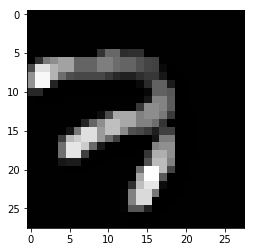

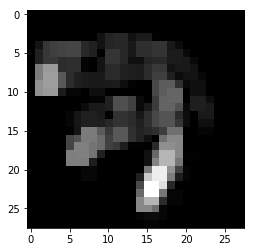

INFO:tensorflow:Restoring parameters from MNIST/model_max2l_.ckpt
(3, 3, 1, 2)
INFO:tensorflow:Restoring parameters from MNIST/model_max2l_.ckpt
(3, 3, 2, 2)


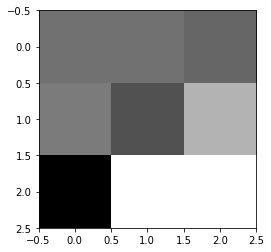

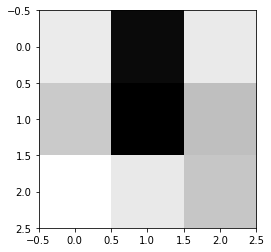

In [79]:
output_cl1 = restore_see_layer(ix=test_img,model_name=model_max,var_name='CL1/max')
print(output_cl1.shape)

output_cl2 = restore_see_layer(ix=test_img,model_name=model_max,var_name='CL2/max')
print(output_cl2.shape)

see_output(output_cl1,1)
see_output(output_cl2,1)

output_cl1_filter = restore_see_layer(ix=test_img,model_name=model_max,var_name='CL1/W')
print(output_cl1_filter.shape)

output_cl2_filter = restore_see_layer(ix=test_img,model_name=model_max,var_name='CL2/W')
print(output_cl2_filter.shape)

see_filter(output_cl1_filter,1)
see_filter(output_cl2_filter,1)

Let's see what happens after 1000 iterations with max pool

In [81]:
train_max(ix=xt,iy=yt,iters=1000,lr=0.001,save_model=True,save_name=model_max,restore_model=False,restore_name=None,v=True)

Iter: 0 Loss: 2.52325
Iter: 1 Loss: 2.10588
Iter: 2 Loss: 1.85213
Iter: 3 Loss: 1.6767
Iter: 4 Loss: 1.53139
Iter: 5 Loss: 1.37711
Iter: 6 Loss: 1.21062
Iter: 7 Loss: 1.03148
Iter: 8 Loss: 0.854594
Iter: 9 Loss: 0.689051
Iter: 10 Loss: 0.540909
Iter: 11 Loss: 0.414639
Iter: 12 Loss: 0.312772
Iter: 13 Loss: 0.232099
Iter: 14 Loss: 0.171793
Iter: 15 Loss: 0.1282
Iter: 16 Loss: 0.0964904
Iter: 17 Loss: 0.0733689
Iter: 18 Loss: 0.056451
Iter: 19 Loss: 0.0442356
Iter: 20 Loss: 0.0351976
Iter: 21 Loss: 0.0282159
Iter: 22 Loss: 0.0227603
Iter: 23 Loss: 0.0185439
Iter: 24 Loss: 0.0152532
Iter: 25 Loss: 0.0126556
Iter: 26 Loss: 0.0106094
Iter: 27 Loss: 0.00897927
Iter: 28 Loss: 0.00766731
Iter: 29 Loss: 0.00660917
Iter: 30 Loss: 0.00574832
Iter: 31 Loss: 0.00504796
Iter: 32 Loss: 0.00447039
Iter: 33 Loss: 0.00399236
Iter: 34 Loss: 0.00359128
Iter: 35 Loss: 0.0032554
Iter: 36 Loss: 0.00297193
Iter: 37 Loss: 0.00272861
Iter: 38 Loss: 0.00252139
Iter: 39 Loss: 0.00234256
Iter: 40 Loss: 0.00218749


INFO:tensorflow:Restoring parameters from MNIST/model_max2l_.ckpt
(1, 28, 28, 2)
INFO:tensorflow:Restoring parameters from MNIST/model_max2l_.ckpt
(1, 28, 28, 2)


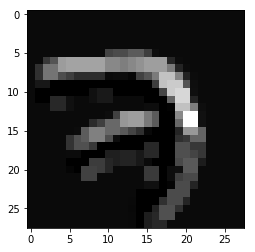

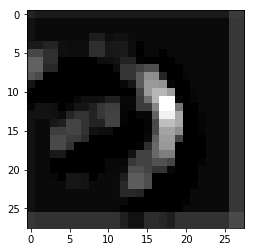

INFO:tensorflow:Restoring parameters from MNIST/model_max2l_.ckpt
(3, 3, 1, 2)
INFO:tensorflow:Restoring parameters from MNIST/model_max2l_.ckpt
(3, 3, 2, 2)


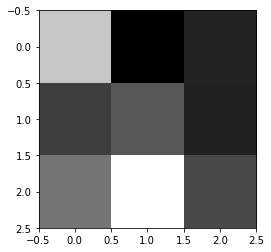

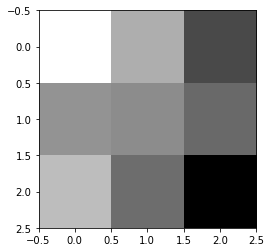

In [82]:
output_cl1 = restore_see_layer(ix=test_img,model_name=model_max,var_name='CL1/max')
print(output_cl1.shape)

output_cl2 = restore_see_layer(ix=test_img,model_name=model_max,var_name='CL2/max')
print(output_cl2.shape)

see_output(output_cl1,1)
see_output(output_cl2,1)

output_cl1_filter = restore_see_layer(ix=test_img,model_name=model_max,var_name='CL1/W')
print(output_cl1_filter.shape)

output_cl2_filter = restore_see_layer(ix=test_img,model_name=model_max,var_name='CL2/W')
print(output_cl2_filter.shape)

see_filter(output_cl1_filter,1)
see_filter(output_cl2_filter,1)